In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

from textblob import TextBlob
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Lambda
from keras.backend import mean
from keras import optimizers

from load_glove_embeddings import load_glove_embeddings

In [14]:
#nltk.download('stopwords')
#nltk.download('wordnet')

In [2]:
def preprocess(words, to_lowercase=True, remove_punctuation=True, remove_digits=True, 
               remove_odd_chars=True, remove_stopwords=True, stem=False, spell_check=False,
               lemmatize=False):
    
    if to_lowercase:
        words = [w.lower() for w in words]
    
    if remove_punctuation:
        words = [w for w in words if not (re.match(r'^\W+$', w) != None)]
    
    if remove_digits:
        words = [w for w in words if not w.replace('.','',1).isdigit()]

    if remove_odd_chars:
        words = [re.sub(r'[^a-zA-Z0-9_]','', w) for w in words]
    
    if remove_stopwords:
        sw = set(nltk.corpus.stopwords.words("english"))
        words = [w for w in words if not w in sw]

    if spell_check:
        words = [str(TextBlob(w).correct()) for w in words]
     
    if stem:
        porter = nltk.PorterStemmer()
        words = [porter.stem(w) for w in words]

    if lemmatize:
        wordnet = nltk.WordNetLemmatizer()
        words = [wordnet.lemmatize(w) for w in words]
        
    return words

def lookup_index(docs):
    output_matrix = []
    for d in docs:
        indices = []
        for w in d:
            if w in word2index.keys():
                indices.append(word2index[w])
            else:
                indices.append(word2index['unk'])
        output_matrix.append(indices)
    return output_matrix

In [3]:
df = pd.read_csv('data/jokes_dataset_CLEAN.csv')
df.head()

,Unnamed: 0,body,id,score,title
0,0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,4,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...
3,5,Because the p is silent.,5tz1o1,0,Why is it unknown on how pterodactyls urinate ...
4,6,To avoid leaving tracks like a snail while wal...,5tz0ef,0,Why women need legs?


In [5]:
df.shape

(130763, 5)

(0, 1000)

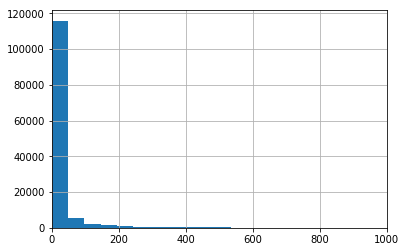

In [13]:
df.score.hist(bins=1000)
plt.xlim(0,1000)

In [14]:
docs = [str(df.title[i]) + ' ' + str(df.body[i]) for i in range(df.shape[0])]

In [23]:
word2index, embedding_matrix = load_glove_embeddings('data/glove.6B.300d.txt', embedding_dim=300)

In [16]:
docs_cleaned = [preprocess(words.split()) for words in docs]

In [26]:
docs_encoded = lookup_index(docs_cleaned)

In [27]:
docs_padded = pad_sequences(docs_encoded, maxlen=60, padding='post')

In [19]:
docs_padded[0]

array([ 5281, 52717,   151,   203,   521,  5309,  5717,   203, 17410,
        3832,  5309,  6043,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [33]:
keras.initializers.glorot_uniform()

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=60,
                            weights=[embedding_matrix], 
                            trainable=False, 
                            name='embedding_layer')

model = Sequential()
model.add(embedding_layer)
model.add(Lambda(lambda x: mean(x where x!= 0, axis=1)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

SyntaxError: invalid syntax (<ipython-input-33-a593b4a76c40>, line 12)

In [30]:
adam = optimizers.adam(lr=0.01)
model.compile(optimizer=adam, loss='mse')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 60, 300)           120000300 
_________________________________________________________________
lambda_2 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               154112    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
__________

In [31]:
model.fit(docs_padded, df.score, epochs=100)

Epoch 1/100
130763/130763 [==============================] - 85s 647us/step - loss: 650501.2427
Epoch 2/100
130763/130763 [==============================] - 78s 595us/step - loss: 649504.7753
Epoch 3/100
130763/130763 [==============================] - 119s 912us/step - loss: 649539.6219
Epoch 4/100
130763/130763 [==============================] - 161s 1ms/step - loss: 649404.2669
Epoch 5/100
 96096/130763 [=====================>........] - ETA: 41s - loss: 670565.2179

KeyboardInterrupt: 

In [50]:
model.evaluate(docs_padded, df.score)

635/635 [==============================] - 0s 244us/step


130476288.503937